In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from xgboost import XGBRegressor
from scipy.stats import randint, uniform

#!pip install shap
import shap

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline

In [ ]:
# get data
defaulted = pd.read_csv('040_defaulted.csv', low_memory=False)
defaulted_test = pd.read_csv('040_defaulted_test.csv', low_memory=False)
oot = pd.read_csv('040_oot.csv', low_memory=False)  # all loans, not just defaulted ones

ytrain = defaulted['LGD']
ytest = defaulted_test['LGD']
yoot = oot['LGD']

xtrain = defaulted.drop(columns=['LGD'])
xtest = defaulted_test.drop(columns=['LGD'])
xoot = oot.drop(columns=['LGD'])

In [ ]:
xtrain.dtypes

,0
currentLoanDelinquencyStatus,object
modificationFlag,object
currentInterestRate,float64
dueDateOfLastPaidInstallment,float64
paymentDeferral,object
estimatedLoanToValue,float64
zeroBalanceRemovalUpb,float64
delinquencyDueToDisaster,object
borrowerAssistanceStatusCode,object
currentMonthModificationCost,float64


In [ ]:
xtrain.columns

Index(['currentLoanDelinquencyStatus', 'modificationFlag',
       'currentInterestRate', 'dueDateOfLastPaidInstallment',
       'paymentDeferral', 'estimatedLoanToValue', 'zeroBalanceRemovalUpb',
       'delinquencyDueToDisaster', 'borrowerAssistanceStatusCode',
       'currentMonthModificationCost', 'upbPctChange', 'nonPmts_3m',
       'delinquencyDueToDisaster_hist', 'creditScore',
       'firstTimeHomebuyerFlag', 'mortgageInsurancePct', 'numberOfUnits',
       'occupancyStatus', 'originalCombinedLoanToValue',
       'originalDebtToIncomeRatio', 'originalUpb', 'originalLoanToValue',
       'originalInterestRate', 'channel', 'propertyState', 'propertyType',
       'loanPurpose', 'originalLoanTerm', 'numberOfBorrowers',
       'superConformingFlag', 'programIndicator', 'reliefRefinanceIndicator',
       'propertyValuationMethod', 'miCancellationIndicator', 'progAtDefault'],
      dtype='object')

In [ ]:
# convert propertyValuationMethod, zeroBalanceCode to str
xtrain['propertyValuationMethod'] = xtrain.propertyValuationMethod.astype(str)
xtest['propertyValuationMethod'] = xtest.propertyValuationMethod.astype(str)
xoot['propertyValuationMethod'] = xoot.propertyValuationMethod.astype(str)


# categorical features encoding, required by xgboost and shap
cat_vars = xtrain.select_dtypes(exclude=['number']).columns.tolist()
num_vars = xtrain.select_dtypes(include=['number']).columns.tolist()

preprocesser = ColumnTransformer(transformers = [
        ('cat', OneHotEncoder(handle_unknown='ignore', drop='first'), cat_vars),
        ('num', 'passthrough', num_vars)
        ])

# define the base model
model = XGBRegressor(
    objective='reg:squarederror',
    tree_method='hist',
    eval_metric='rmse',
    random_state=251417829,
    n_jobs=-1,
    # early_stopping_rounds=10
    )

# define pipeline
pipe = Pipeline(steps = [
    ('preprocesser', preprocesser),
    ('model', model)
    ])

In [ ]:
# define randomized param grid
param_dist = {
    'model__n_estimators': randint(50, 200),
    'model__max_depth': randint(2, 5),
    'model__learning_rate': uniform(0.01, 0.2),
    'model__subsample': uniform(0.6, 0.4),
    'model__colsample_bytree': uniform(0.7, 0.3),
    'model__gamma': uniform(0, 0.2),
    'model__reg_alpha': uniform(0, 1),
    'model__reg_lambda': uniform(0, 1)
    }

# define grid search object, refit = True by default
searchcv = RandomizedSearchCV(
    estimator = pipe,
    param_distributions = param_dist,
    n_iter = 500,
    scoring = 'neg_mean_squared_error',
    cv =3,
    verbose = 1,
    random_state = 251417829,
    n_jobs=-1
    )

searchcv.fit(xtrain, ytrain)

Fitting 3 folds for each of 500 candidates, totalling 1500 fits


RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('preprocesser',
                                              ColumnTransformer(transformers=[('cat',
                                                                               OneHotEncoder(drop='first',
                                                                                             handle_unknown='ignore'),
                                                                               ['currentLoanDelinquencyStatus',
                                                                                'modificationFlag',
                                                                                'paymentDeferral',
                                                                                'delinquencyDueToDisaster',
                                                                                'borrowerAssistanceStatusCode',
                                                                                'delinquencyDueToDisaster_hist',
                                                                                'firstTimeHomebuyerFlag',
                                                                                'occupanc...
                                        'model__reg_alpha': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7db0fa431750>,
                                        'model__reg_lambda': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7db0fa47a090>,
                                        'model__subsample': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7db0fa447690>},
                   random_state=251417829, scoring='neg_mean_squared_error',
                   verbose=1)

In [ ]:
# inspect the fitting process
results = pd.DataFrame(searchcv.cv_results_)


In [ ]:
score_cols = [col for col in results.columns if col.startswith('mean_test_')]
results = results[[i for i in (['params', 'rank_test_score'] + score_cols)]]
results.sort_values(by='rank_test_score', ascending=True)

,params,rank_test_score,mean_test_score
153,{'model__colsample_bytree': 0.8478576052671318...,1,-0.003332
468,{'model__colsample_bytree': 0.7802254070152039...,2,-0.003338
51,{'model__colsample_bytree': 0.8043285982903046...,3,-0.003340
148,{'model__colsample_bytree': 0.8848364574495284...,4,-0.003341
246,{'model__colsample_bytree': 0.7495344075547797...,5,-0.003341
...,...,...,...
61,{'model__colsample_bytree': 0.7690533207034251...,496,-0.003796
91,{'model__colsample_bytree': 0.9607705166842959...,497,-0.003808
270,{'model__colsample_bytree': 0.8752269553470995...,498,-0.003809
221,{'model__colsample_bytree': 0.7027176812931515...,499,-0.003897


In [ ]:
for k,v in searchcv.best_params_.items():
    print(k, ':', v)
print("\nBest score (cross-validation neg_mean_squared_error):", searchcv.best_score_)

model__colsample_bytree : 0.8478576052671318
model__gamma : 0.009986453602482426
model__learning_rate : 0.03560947817853645
model__max_depth : 4
model__n_estimators : 106
model__reg_alpha : 0.5998484304178087
model__reg_lambda : 0.21726214703721514
model__subsample : 0.9970059748861763

Best score (cross-validation neg_mean_squared_error): -0.003332288051717242


In [ ]:
# test performance, the refitted best model becomes accessible via searchcv.predict()
pred_test = searchcv.predict(xtest)

# calculate the error
mse = mean_squared_error(pred_test, ytest)
np.sqrt(mse)

np.float64(0.06733272440967215)

In [ ]:
pd.DataFrame({
    'test_LGDpred': pred_test,
    'test_LGD': ytest
})

,test_LGDpred,test_LGD
0,0.015392,0.000000
1,0.006972,0.000000
2,0.006972,0.000000
3,0.012169,0.000000
4,0.007314,0.000000
...,...,...
391,0.007238,0.002292
392,0.007238,0.000000
393,0.012461,0.003033
394,0.008702,0.000000


apply to the whole OOT sample directly

In [ ]:
# use fitted model to predict on the whole OOT sample
pred_oot = searchcv.predict(xoot)

/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [ ]:
predoot = pd.DataFrame({
    'LGD_hat': pred_oot,
    'LGD': yoot
    })

predoot

,LGD_hat,LGD
0,0.006972,0.0
1,0.012169,0.0
2,0.008428,NaN
3,0.006972,NaN
4,0.006972,NaN
...,...,...
252,0.008702,NaN
253,0.008702,NaN
254,0.008836,NaN
255,0.008702,NaN


In [ ]:
predoot.loc[predoot.LGD_hat < 0.05, 'LGD_hat'] = 0.05
predoot

,LGD_hat,LGD
0,0.05,0.0
1,0.05,0.0
2,0.05,NaN
3,0.05,NaN
4,0.05,NaN
...,...,...
252,0.05,NaN
253,0.05,NaN
254,0.05,NaN
255,0.05,NaN


In [ ]:
predoot.to_csv('./041_LGD_pred_oot.csv', index=False)

#### shap values

In [ ]:
# Extract the trained model from the pipeline
trained_model = searchcv.best_estimator_.named_steps['model']

# Apply the preprocessing steps to xtest, now has 396 rows and 189 cols
xtest_processed = searchcv.best_estimator_.named_steps['preprocesser'].transform(xtest)

explainer = shap.TreeExplainer(trained_model)
shap_values = explainer(xtest_processed)

In [ ]:
# Get the base value (expected value)
base_value = explainer.expected_value
print(f"Base value, base_value: {base_value:.4f}")
print(f"SHAP values, shap_values, shape: {shap_values.shape}")
print(f"Test set shape: {xtest.shape}")

Base value, base_value: 0.0133
SHAP values, shap_values, shape: (396, 98)
Test set shape: (396, 35)


Waterfall Plot for First Prediction


In [ ]:
def get_feature_names_from_pipeline(pipeline):
    """Gets feature names from a pipeline with a ColumnTransformer and OneHotEncoder."""
    feature_names = []
    for name, transformer, columns in pipeline.named_steps['preprocesser'].transformers_:
        if name == 'cat':
            # Handle OneHotEncoder
            if hasattr(transformer, 'get_feature_names_out'):
                feature_names.extend(transformer.get_feature_names_out(columns))
            else:
                # Fallback for older versions
                for col in columns:
                    for category in transformer.categories_[columns.index(col)]:
                        feature_names.append(f"{col}_{category}")
        elif name == 'num':
            # Handle passthrough (numeric features)
            feature_names.extend(columns)
    return feature_names

feature_names = get_feature_names_from_pipeline(searchcv.best_estimator_)
feature_names  # looks correct

['currentLoanDelinquencyStatus_10',
 'currentLoanDelinquencyStatus_11',
 'currentLoanDelinquencyStatus_12',
 'currentLoanDelinquencyStatus_13',
 'currentLoanDelinquencyStatus_14',
 'currentLoanDelinquencyStatus_15',
 'currentLoanDelinquencyStatus_16',
 'currentLoanDelinquencyStatus_17',
 'currentLoanDelinquencyStatus_18',
 'currentLoanDelinquencyStatus_19',
 'currentLoanDelinquencyStatus_20',
 'currentLoanDelinquencyStatus_21',
 'currentLoanDelinquencyStatus_22',
 'currentLoanDelinquencyStatus_23',
 'currentLoanDelinquencyStatus_24',
 'currentLoanDelinquencyStatus_25',
 'currentLoanDelinquencyStatus_26',
 'currentLoanDelinquencyStatus_27',
 'currentLoanDelinquencyStatus_28',
 'currentLoanDelinquencyStatus_29',
 'currentLoanDelinquencyStatus_30',
 'currentLoanDelinquencyStatus_31',
 'currentLoanDelinquencyStatus_32',
 'currentLoanDelinquencyStatus_33',
 'currentLoanDelinquencyStatus_34',
 'currentLoanDelinquencyStatus_35',
 'currentLoanDelinquencyStatus_36',
 'currentLoanDelinquencyStat

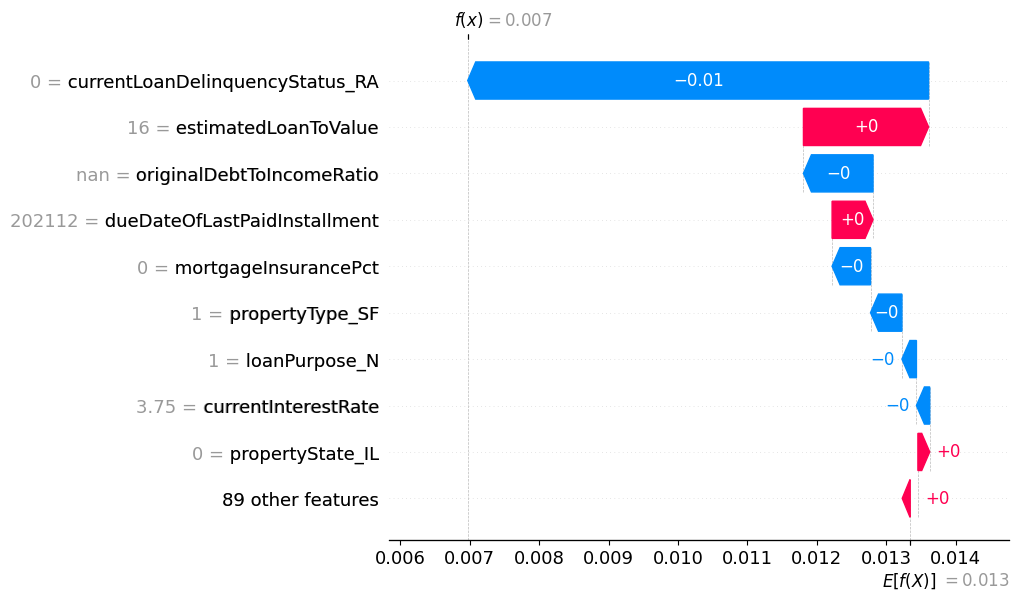

Actual LGD: 0.0000

Predicted LGD: 0.0070

Base value (expected prediction): 0.0133


In [ ]:
plt.figure(figsize=(10, 8))
shap.waterfall_plot(
    shap.Explanation(
        values = shap_values[1],  # shap values for the first sample
        base_values = base_value,
        data = xtest.iloc[1],
        feature_names = feature_names
    )
)

print(f'Actual LGD: {ytest.iloc[1]:.4f}')
print(f'\nPredicted LGD: {pred_test[1]:.4f}')
print(f"\nBase value (expected prediction): {base_value:.4f}")


Summary Plot for All Features

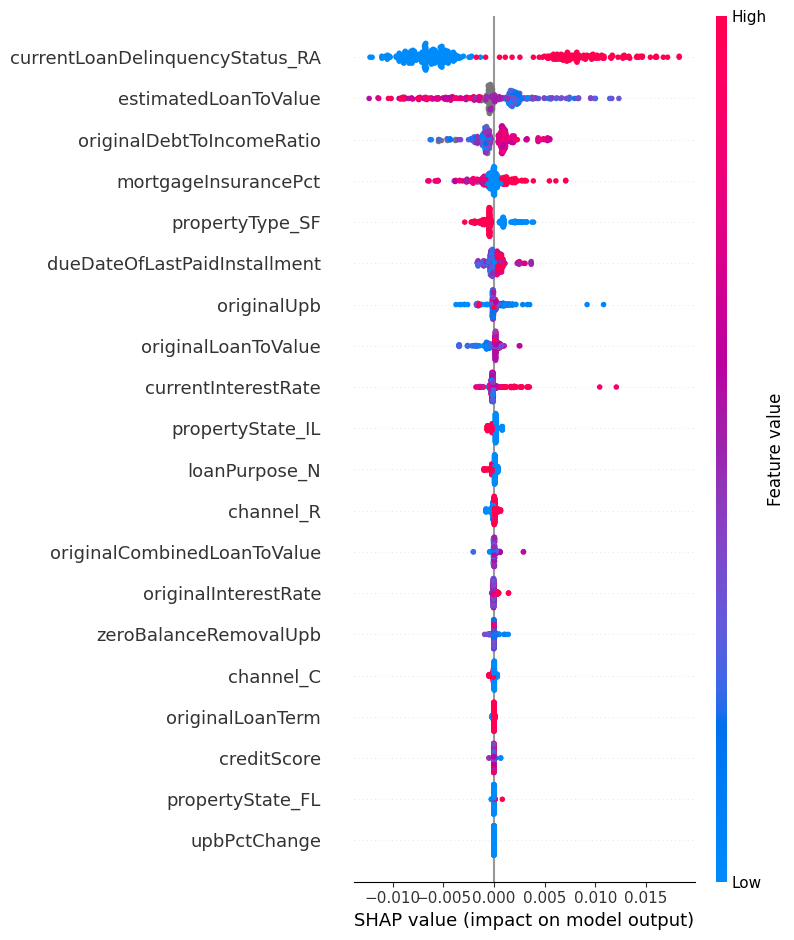

In [ ]:
plt.figure(figsize=(12, 8))

# Convert the sparse matrix to a dense array for plotting
xtest_processed_dense = xtest_processed.toarray()

shap.summary_plot(
  shap_values,
  xtest_processed_dense,   # Use the dense array
  feature_names = feature_names
)

<Axes: xlabel='originalDebtToIncomeRatio', ylabel='LGD'>

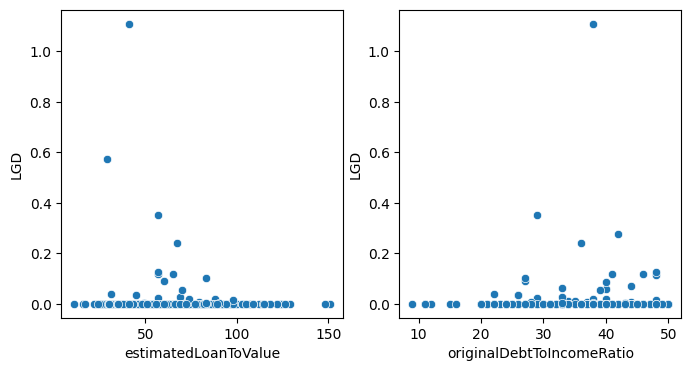

In [ ]:
# show the relationship between LGD and estimatedLoanToValue, and LGD and originalDebtToIncomeRatio
fig, ax = plt.subplots(1, 2, figsize=(8,4))

sns.scatterplot(x=xtest['estimatedLoanToValue'], y = ytest, ax=ax[0])
sns.scatterplot(x=xtest['originalDebtToIncomeRatio'], y = ytest, ax=ax[1])